Кількість записів у файлі: 1030
   Cement (component 1)(kg in a m^3 mixture)  \
0                                      540.0   
1                                      540.0   
2                                      332.5   
3                                      332.5   
4                                      198.6   

   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
0                                                0.0       
1                                                0.0       
2                                              142.5       
3                                              142.5       
4                                              132.4       

   Fly Ash (component 3)(kg in a m^3 mixture)  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Water  (component 4)

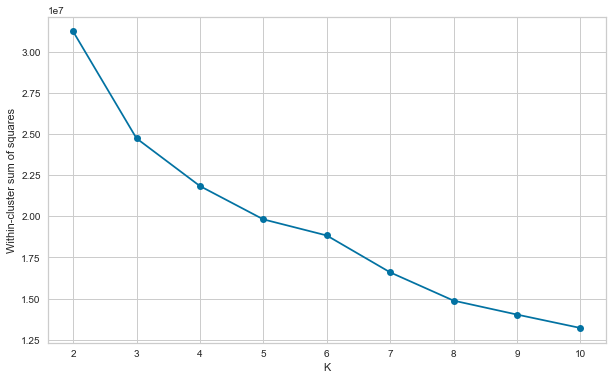

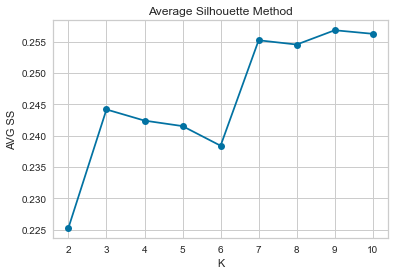

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


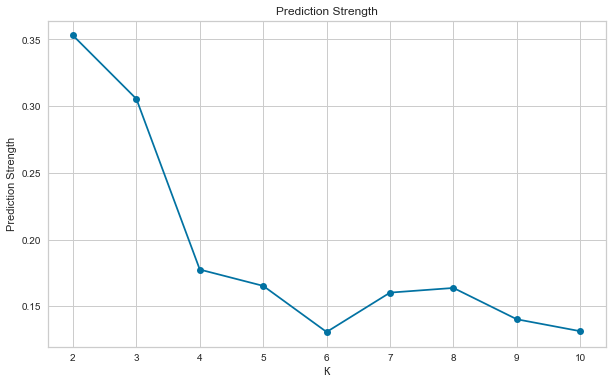

Найкращий варіант кластеризації з кількістю кластерів 3
Silhouette Score : 0.24417983917267727
Центри:
[[ 399.37432836   30.93522388   26.03761194  182.67731343    6.25731343
   959.01671642  757.9961194    58.70447761]
 [ 224.79884058   11.42318841  101.92492754  173.62231884    7.02
  1016.41275362  814.60173913   39.06376812]
 [ 223.59114286  176.59542857   34.078       188.33628571    5.35057143
   943.35285714  748.06171429   39.68285714]]


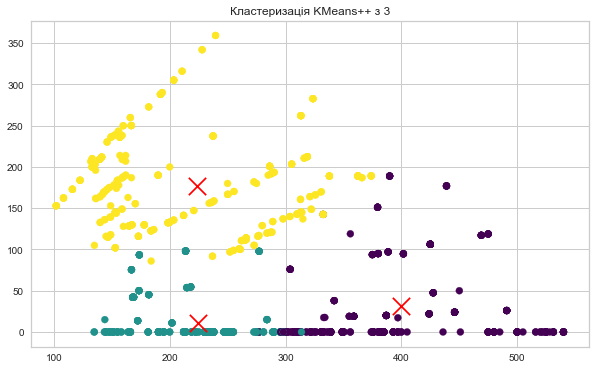

Координати центрів кластерів (агломеративна кластеризація):
[[ 405.424        86.2596       13.604       181.56          7.9552
   931.8536      742.2304       80.048     ]
 [ 200.26818182  172.5486014    46.62657343  188.76923077    5.18811189
   947.67762238  748.64825175   30.61888112]
 [ 265.12186235   10.52408907   79.1048583   177.401417      5.90728745
  1008.31437247  803.88036437   36.96963563]]
AgglomerativeClustering SS: 0.23399705827162537
k-means++ SS: 0.24417983917267727


In [14]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split



file_path = 'dataset3_l5.csv'

# 1. Завантажити та зчитати файл з даними
with open(file_path, 'r', encoding='utf-8') as file:
    df = file.read()

df = df.replace(',', '.')

# Зберігаємо відредагований текст у новий CSV файл
fixed_file_path = 'D:/Unic/Y3/Sem2/ML/L5/dataset3_l5_fixed.csv'
with open(fixed_file_path, 'w', encoding='utf-8') as file:
    file.write(df)    

# Зчитуємо відредагований CSV файл з правильним сепаратором
df = pd.read_csv(fixed_file_path, sep=';')

# 2.  Визначити та вивести кількість записів. 
recordnum = len(df)
print(f"Кількість записів у файлі: {recordnum}")
print(df.head())

# 3.  Видалити атрибут Concrete compressive strength. 
df.drop(columns=['Concrete compressive strength(MPa. megapascals) '], inplace=True)

# 4.  Вивести атрибути, що залишилися.
remaining_fields = df.columns.tolist()
print(f"Поля, що лишилися: {remaining_fields}")


# 5. Кластеризація
# Виконуємо кластеризацію з випадковою початковою ініціалізацією
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df)
centers = kmeans.cluster_centers_
print("Cluster centers:")
print(centers)

# Метод ліктя
model = KMeans(random_state=42)
se =[]
for k in range(2,11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df)

  se.append(kmeans.inertia_)

_, ax = plt.subplots(figsize=(10, 6))

plt.plot(range(2,11), se, 'o-')
plt.xlabel("K")
plt.ylabel("Within-cluster sum of squares")
plt.show()

range_n_clusters = list(range(2, 11))
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(df, cluster_labels))

plt.figure()
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel('K')
plt.ylabel('AVG SS')
plt.title('Average Silhouette Method')
plt.show()

def prediction_strength(df, k_range, M=10, random_state=None):
    def cluster_data(df, n_clusters):
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        labels = kmeans.fit_predict(df)
        return kmeans.cluster_centers_, labels
    
    def pred_str(train_data, test_data, k):
        train_centers, train_labels = cluster_data(train_data, k)
        test_centers, test_labels = cluster_data(test_data, k)

        predicted_labels, _ = pairwise_distances_argmin_min(test_data, train_centers)
        
        correct_predictions = sum(test_labels == predicted_labels)
        prediction_strength = correct_predictions / len(test_labels)
        
        return prediction_strength
    
    strengths = {}
    for k in k_range:
        strength_scores = []
        for i in range(M):
            train_data, test_data = train_test_split(df, test_size=0.5, random_state=random_state if random_state is None else random_state + i)
            strength = pred_str(train_data, test_data, k)
            strength_scores.append(strength)
        strengths[k] = np.mean(strength_scores)
    
    return strengths

k_range = range(2, 11)
strengths = prediction_strength(df, k_range, M=10, random_state=42)
plt.figure(figsize=(10, 6))
plt.plot(list(strengths.keys()), list(strengths.values()), marker='o')
plt.xlabel('К')
plt.ylabel('Prediction Strength')
plt.title('Prediction Strength')
plt.grid(True)
plt.legend()
plt.show()

k_best = 3
def multiple_kmeans(data, n_clusters, n_init=10, random_state=None):
    best_kmeans = None
    best_silhouette = -1
    
    for i in range(n_init):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, random_state=random_state if random_state is None else random_state + i)
        kmeans.fit(data)
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_kmeans = kmeans
    
    return best_kmeans, best_silhouette

best_kmeans, best_silhouette = multiple_kmeans(df, k_best, n_init=10, random_state=42)

print(f"Найкращий варіант кластеризації з кількістю кластерів {k_best}")
print(f"Silhouette Score : {best_silhouette}")
print("Центри:")
print(best_kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=best_kmeans.labels_, cmap='viridis', marker='o')
plt.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title(f'Кластеризація KMeans++ з {k_best}')
plt.show()


agg_clustering = AgglomerativeClustering(n_clusters=k_best)
agg_labels = agg_clustering.fit_predict(df)


centers = []
for i in range(k_best):
    cluster_points = df[agg_labels == i]
    center = cluster_points.mean(axis=0)
    centers.append(center)
centers = np.array(centers)
print(f"Координати центрів кластерів (агломеративна кластеризація):\n{centers}")
print(f"AgglomerativeClustering SS: {silhouette_score(df, agg_labels)}")
print(f"k-means++ SS: {best_silhouette}")
